<h1>Dataset preparation and model training for quick development and trial throughout the project -- Used in earlier sprints</h1>

<h3> Initial model training in jupyter notebook. Aim was to get a grasp of how to clean, preprocess, train-test and predict the models, and also find out which model would be best suited out of: Random Forest, SVM, KNN, and Decision Tree </h3>

In [1]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [ ]:


#load Enron dataset
data_path = 'data/CEAS_08.csv'
data = pd.read_csv(data_path)



In [ ]:


#inspect
print(data.head())
print(data['label'].value_counts()) #checking the label distri



In [13]:
#check missing vals
print(data.isnull().sum())

sender        0
receiver    462
date          0
subject      28
body          0
label         0
urls          0
dtype: int64


<h2>clean email text</h2>

In [23]:
#drop rows w missung vals in body column
data = data.dropna(subset=['body'])

In [27]:
def clean_text(body):
    body = body.lower() 
    body = re.sub(r'\s+', ' ', body).strip()  # Remove extra whitespace
    return body

In [28]:
data['cleaned_email'] = data['body'].apply(clean_text)

In [29]:
#inspect the cleaned data
print(data[['body', 'cleaned_email']].head())

                                                body  \
0  Buck up, your troubles caused by small dimensi...   
1  \nUpgrade your sex and pleasures with these te...   
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...   
3  Would anyone object to removing .so from this ...   
4  \nWelcomeFastShippingCustomerSupport\nhttp://7...   

                                       cleaned_email  
0  buck up, your troubles caused by small dimensi...  
1  upgrade your sex and pleasures with these tech...  
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...  
3  would anyone object to removing .so from this ...  
4  welcomefastshippingcustomersupport http://7iwf...  


In [31]:
# split dataset into training and testing sets 
X = data['cleaned_email']
y = data['label']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# TFIDF vectorizer for feature extraction
vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('english'))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

<h2>Training the model</h2>

In [34]:
rf_model = RandomForestClassifier(random_state=42)

In [36]:
#Train
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [37]:
#predict
y_pred = rf_model.predict(X_test_tfidf)


In [38]:
#Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9927212361128847
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3490
           1       0.99      0.99      0.99      4341

    accuracy                           0.99      7831
   macro avg       0.99      0.99      0.99      7831
weighted avg       0.99      0.99      0.99      7831



In [40]:
import joblib

#save
joblib.dump(rf_model, 'models/random_forest_model.pkl')

#save the TF-IDF vectorizer
joblib.dump(vectorizer, 'models/tfidf_vectorizer.pkl')

print("Model and vectorizer successfully saved")

Model and vectorizer successfully saved


In [ ]:
#hyperparameter tuning for rf

from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1')
grid_search.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

<h2>Feature Extraction on old dataset to ignore for now</h2>

In [16]:
#oversampling
from sklearn.utils import resample
phshing = data[data['label'] == 1]
non_phishing = data[data['label'] == 0]

oversampled_phishing = resample(phishing, replace=True, n_samples=len(non_phishing), random_state=42)
balanced_data = pd.concat([oversampled_phishing, non_phishing])

In [17]:
#Feature extraction using tf-idf vectorizer
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(data['processed_message'])

#extracting target var 
y = data['label']

#training and testing set split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


<h2> Evaluation and training the models </h2>

In [18]:
#train DT classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

#predictions
dt_predictions = dt_model.predict(X_test)

#evaluate DT model
print("Decision Tree Performance:")
print("Accuracy:", accuracy_score(y_test, dt_predictions))
print("Confusion Matrix:\n", classification_report(y_test, dt_predictions))
print("Classification Report:\n", classification_report(y_test, dt_predictions))


Decision Tree Performance:
Accuracy: 0.9666995226222918
Confusion Matrix:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     35407
           1       0.95      0.95      0.95     16334

    accuracy                           0.97     51741
   macro avg       0.96      0.96      0.96     51741
weighted avg       0.97      0.97      0.97     51741

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     35407
           1       0.95      0.95      0.95     16334

    accuracy                           0.97     51741
   macro avg       0.96      0.96      0.96     51741
weighted avg       0.97      0.97      0.97     51741



In [19]:
#train Random Forest classifier.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

#predictions 
rf_predictions = rf_model.predict(X_test)

#evaluate RF 
print("Random Forest Performance:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print("Confusion Matrix\n", confusion_matrix(y_test, rf_predictions))
print("Classification Report:\n", classification_report(y_test, rf_predictions))

Random Forest Performance:
Accuracy: 0.9747588952668097
Confusion Matrix
 [[35288   119]
 [ 1187 15147]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     35407
           1       0.99      0.93      0.96     16334

    accuracy                           0.97     51741
   macro avg       0.98      0.96      0.97     51741
weighted avg       0.98      0.97      0.97     51741



In [20]:
from sklearn.neighbors import KNeighborsClassifier

# init with val 5 
knn_model = KNeighborsClassifier(n_neighbors=5)

#train knn model
knn_model.fit(X_train, y_train)

# predict
knn_predictions = knn_model.predict(X_test)

#evaluate
print("K-Nearest Neighbors Performance:")
print("Accuracy:", accuracy_score(y_test, knn_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predictions))
print("Classification Report:\n", classification_report(y_test, knn_predictions))

K-Nearest Neighbors Performance:
Accuracy: 0.9203726251908545
Confusion Matrix:
 [[33786  1621]
 [ 2499 13835]]
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94     35407
           1       0.90      0.85      0.87     16334

    accuracy                           0.92     51741
   macro avg       0.91      0.90      0.91     51741
weighted avg       0.92      0.92      0.92     51741



           Model  Accuracy
0  Decision Tree  0.966700
1  Random Forest  0.974759
2            KNN  0.920373


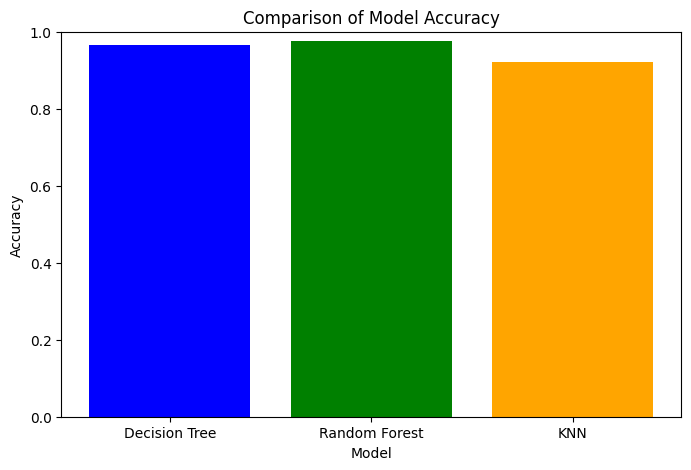

In [28]:
#metrics
results = {
    "Model": ["Decision Tree", "Random Forest", "KNN"],
    "Accuracy": [
        accuracy_score(y_test, dt_predictions),
        accuracy_score(y_test, rf_predictions),
        accuracy_score(y_test, knn_predictions)
    ]
}

#dataframe to copmrae
results_df = pd.DataFrame(results)
print(results_df)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(results_df['Model'], results_df['Accuracy'], color=['blue', 'green', 'orange', 'purple'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy")
plt.ylim(0, 1)
plt.show()

In [21]:
import joblib

In [22]:
#save DT model
joblib.dump(dt_model, 'decision_tree_model.pkl')

# save RF model
joblib.dump(rf_model, 'random_forest_model.pkl')

#save KNN model
joblib.dump(knn_model, 'knn_model.pkl')

print("All models saved")

All models saved


In [25]:
#load models
loaded_dt_model = joblib.load('decision_tree_model.pkl')
loaded_rf_model = joblib.load('random_forest_model.pkl')
loaded_knn_model = joblib.load('knn_model.pkl')

print("All models loaded")

All models loaded


In [ ]:
#predict with loaded models
dt_loaded_predictions = loaded_dt_model.predict(X_test)
rf_loaded_predictions = loaded_rf_model.predict(X_test)
knn_loaded_predictions = loaded_knn_model.predict(X_test)

#check accuracy to confirm models loaded correctly
print("Loaded Decision Tree Accuracy:", accuracy_score(y_test, dt_loaded_predictions))
print("Loaded Random Forest Accuracy:", accuracy_score(y_test, rf_loaded_predictions))
print("Loaded KNN Accuracy:", accuracy_score(y_test, knn_loaded_predictions))

In [29]:
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']